In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import gradient_descent
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

cuda


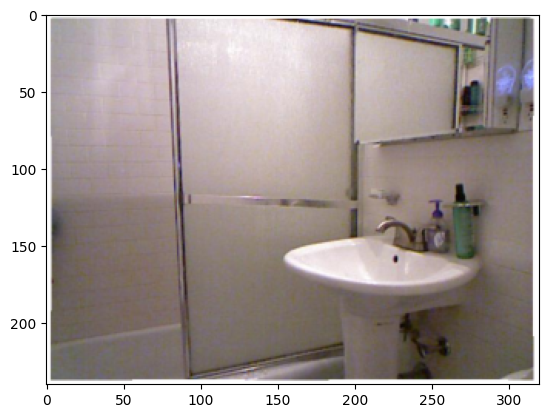

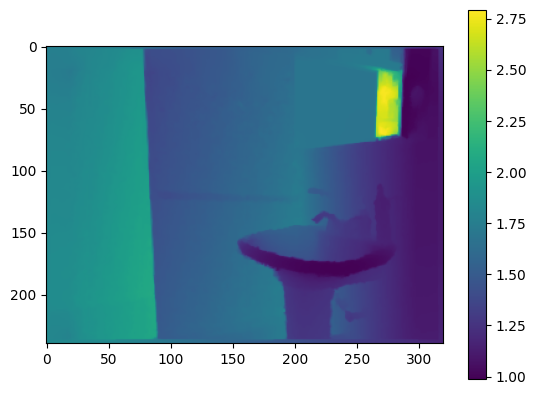

adaptive kernel size set to 11


In [2]:
globals.init_NYUv2()

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
gt_aif, gt_dpt = utils.load_single_sample(sample='0048', set='train', fs=5, res='half')
# gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

plt.imshow(gt_aif / IMAGE_RANGE)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.046185784..1.0061072].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06516443..1.00053].


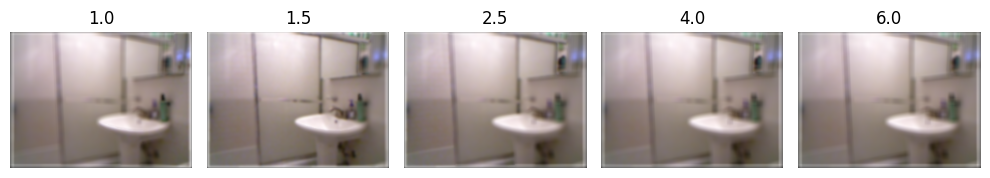

In [3]:
# forward model (torch)
FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)
defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack_torch / IMAGE_RANGE, globals.Df)



In [ ]:
# test -- can the PGD reconstruct the ground truth AIF from the ground truth depth map?

recon_aif = least_squares.bounded_fista(gt_dpt, defocus_stack, IMAGE_RANGE, maxiter=2000, gt=gt_aif)

utils.plot_compare_rgb(gt_aif, recon_aif)
plt.show()

print(torch.mean((gt_aif - recon_aif)**2).item())

In [ ]:
recon_aif = least_squares.least_squares(gt_dpt, defocus_stack, maxiter = 500)
utils.plot_compare_rgb(gt_aif, recon_aif)
plt.show()

print(torch.mean((gt_aif - recon_aif)**2).item())

In [ ]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05, sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

In [4]:
# -------------------
# COORDINATE DESCENT
# -------------------

depth_init = 1#torch.median(gt_dpt.cpu()).item()
# print('initializing depth to',depth_init)

dpt, aif, _ = coordinate_descent.coordinate_descent(defocus_stack, show_plots=False,
                                                 save_plots=True, num_epochs=40,
                                                 least_squares_first=True, depth_init=depth_init,
                                                 # least_squares_first=False, aif_init=aif_init, 
                                                 aif_method='fista', finite_differences=False,
                                                    k=3,
                                                num_Z=100, ls_maxiter=200, ls_maxiter_multiplier=1.05,#1.075, 
                                                 use_CUDA=False, vmin = gt_dpt.min(), vmax = gt_dpt.max())


Created experiment folder: experiments/coord-descent_2025-08-11_12-47-37
Images in range [0-255]
Iteration 0 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03549409]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.035494090647144316.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03549409]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 10.055155277252197


Optimizing: 100%|█████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


r1norm 5960.52827100203 norm(x) 75102.01177133653

AIF result range: [ 0.0 , 255.0 ]
Loss: 30.84016227722168 , TV: 7126415.016679557
Loss after clipping: 30.84016227722168 , TV: 7126415.016679557



Grid search         : 100%|███████████████████| 100/100 [00:27<00:00,  3.67it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 5.27962457843289 , TV: 80530.11019951844

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 210


--------------------------

Iteration 1 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04245278]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.042394695107793805.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0423947]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.051894903182983


Optimizing: 100%|█████████████████████████████| 210/210 [01:13<00:00,  2.84it/s]


r1norm 1580.8848249436169 norm(x) 74549.6542650152

AIF result range: [ 0.0 , 255.0 ]
Loss: 2.1694331720854088 , TV: 7151871.665702163
Loss after clipping: 2.1694331720854088 , TV: 7151871.665702163



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.59it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 1.096991441748157 , TV: 49651.61445171556

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 220


--------------------------

Iteration 2 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05030528]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05030527982194439.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05030528]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.714824438095093


Optimizing: 100%|█████████████████████████████| 220/220 [01:19<00:00,  2.76it/s]


r1norm 635.2455041975005 norm(x) 73888.00217499062

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.3502904000050837 , TV: 4035232.780242765
Loss after clipping: 0.3502904000050837 , TV: 4035232.780242765



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.76it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.19662004041606476 , TV: 22009.92447178071

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 231


--------------------------

Iteration 3 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04474023]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04474023196752311.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04474023]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.5507519245147705


Optimizing: 100%|█████████████████████████████| 231/231 [01:23<00:00,  2.77it/s]


r1norm 355.68744283882273 norm(x) 73816.20333375764

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.10981966211235623 , TV: 3033102.163483671
Loss after clipping: 0.10981966211235623 , TV: 3033102.163483671



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.61it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.08108980693926097 , TV: 9190.925457912854

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 242


--------------------------

Iteration 4 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05016045]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05016045180344246.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05016045]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.935420751571655


Optimizing: 100%|█████████████████████████████| 242/242 [01:27<00:00,  2.77it/s]


r1norm 267.7581728178784 norm(x) 73801.04635598819

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.062234014930538456 , TV: 2693764.3989047706
Loss after clipping: 0.062234014930538456 , TV: 2693764.3989047706



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.51it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.056946172252344114 , TV: 4980.388134465956

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 254


--------------------------

Iteration 5 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04002868]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04002867933054378.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04002868]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.327890157699585


Optimizing: 100%|█████████████████████████████| 254/254 [01:31<00:00,  2.78it/s]


r1norm 244.0766926625629 norm(x) 73800.52468314505

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0517125394578327 , TV: 2601054.607008838
Loss after clipping: 0.0517125394578327 , TV: 2601054.607008838



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.65it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.04946452956588349 , TV: 3970.388858467635

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 266


--------------------------

Iteration 6 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04261403]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.042614027761550356.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04261403]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.112514972686768


Optimizing: 100%|█████████████████████████████| 266/266 [01:37<00:00,  2.73it/s]


r1norm 232.23008971739048 norm(x) 73804.58040488836

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.046814475994740076 , TV: 2595262.94679317
Loss after clipping: 0.046814475994740076 , TV: 2595262.94679317



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.52it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.04516395657423463 , TV: 3612.2125467503984

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 279


--------------------------

Iteration 7 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04542348]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.045423482511616216.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04542348]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.224419355392456


Optimizing: 100%|█████████████████████████████| 279/279 [01:42<00:00,  2.73it/s]


r1norm 219.7106070785649 norm(x) 73803.25132288376

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.041902970732548964 , TV: 2577809.1268833843
Loss after clipping: 0.041902970732548964 , TV: 2577809.1268833843



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.63it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.04073625714883506 , TV: 3363.0173345008807

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 292


--------------------------

Iteration 8 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03248587]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.032485873211344246.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03248587]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.581740140914917


Optimizing: 100%|█████████████████████████████| 292/292 [01:47<00:00,  2.71it/s]


r1norm 213.28587564221309 norm(x) 73805.1536056725

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.03948822653987728 , TV: 2579904.0706773433
Loss after clipping: 0.03948822653987728 , TV: 2579904.0706773433



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.53it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.03829543002378334 , TV: 3244.1471204496684

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 306


--------------------------

Iteration 9 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04879509]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04879509072513309.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04879509]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.205364465713501


Optimizing: 100%|█████████████████████████████| 306/306 [01:52<00:00,  2.73it/s]


r1norm 204.09536174781496 norm(x) 73806.7370126551

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.03615840848685167 , TV: 2591246.037425325
Loss after clipping: 0.03615840848685167 , TV: 2591246.037425325



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.45it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.03505708377378686 , TV: 3074.357547712198

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 321


--------------------------

Iteration 10 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.06013092]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.06013091501532551.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.06013092]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.0815980434417725


Optimizing: 100%|█████████████████████████████| 321/321 [01:58<00:00,  2.70it/s]


r1norm 194.89696446162358 norm(x) 73808.11368412498

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.03297265828087643 , TV: 2594777.6913723713
Loss after clipping: 0.03297265828087643 , TV: 2594777.6913723713



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.75it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.03211003010062867 , TV: 2949.631840294181

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 337


--------------------------

Iteration 11 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03708317]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.03696975536034433.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03696976]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.2404468059539795


Optimizing: 100%|█████████████████████████████| 337/337 [02:05<00:00,  2.69it/s]


r1norm 186.84194944712243 norm(x) 73807.14085631791

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0303034999415246 , TV: 2586290.397543736
Loss after clipping: 0.0303034999415246 , TV: 2586290.397543736



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.62it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.029733234878056035 , TV: 2829.5177555157416

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 353


--------------------------

Iteration 12 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03092098]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.030920982853488897.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03092098]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.426407814025879


Optimizing: 100%|█████████████████████████████| 353/353 [02:08<00:00,  2.76it/s]


r1norm 180.82849100353155 norm(x) 73807.72084815912

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.028384333471787645 , TV: 2582648.406100023
Loss after clipping: 0.028384333471787645 , TV: 2582648.406100023



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.54it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.027831292439102113 , TV: 2843.6716482370916

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 370


--------------------------

Iteration 13 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02839817]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.02839817488643746.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02839817]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.3456902503967285


Optimizing: 100%|█████████████████████████████| 370/370 [02:14<00:00,  2.76it/s]


r1norm 173.3523654636232 norm(x) 73808.8505121815

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.026085829998112226 , TV: 2590171.3643190395
Loss after clipping: 0.026085829998112226 , TV: 2590171.3643190395



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.71it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.025143155848590237 , TV: 2681.217871614809

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 388


--------------------------

Iteration 14 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02936248]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.029362480450474144.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02936248]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.5843894481658936


Optimizing: 100%|█████████████████████████████| 388/388 [02:20<00:00,  2.77it/s]


r1norm 165.82709313212052 norm(x) 73807.98520887567

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.023870195003351607 , TV: 2595848.0631023785
Loss after clipping: 0.023870195003351607 , TV: 2595848.0631023785



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.71it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.022869950451493162 , TV: 2598.928954615397

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 407


--------------------------

Iteration 15 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02950429]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.029504293681997557.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02950429]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.576615810394287


Optimizing: 100%|█████████████████████████████| 407/407 [02:25<00:00,  2.79it/s]


r1norm 154.36545619496124 norm(x) 73803.47842960381

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.020684527725186568 , TV: 2586213.68311431
Loss after clipping: 0.020684527725186568 , TV: 2586213.68311431



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.81it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.019686847522272892 , TV: 2503.7839841820164

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 427


--------------------------

Iteration 16 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03801068]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.038010679021523795.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03801068]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.56478214263916


Optimizing: 100%|█████████████████████████████| 427/427 [02:34<00:00,  2.77it/s]


r1norm 145.5910171539652 norm(x) 73801.37138809463

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.018399875667378423 , TV: 2560059.20294505
Loss after clipping: 0.018399875667378423 , TV: 2560059.20294505



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.61it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0173783113610941 , TV: 2357.6521429233476

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 448


--------------------------

Iteration 17 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04572995]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.045729951581941396.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04572995]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.372726678848267


Optimizing: 100%|█████████████████████████████| 448/448 [02:40<00:00,  2.79it/s]


r1norm 132.52718464621208 norm(x) 73793.52243551004

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.015246001264219189 , TV: 2527372.8240412003
Loss after clipping: 0.015246001264219189 , TV: 2527372.8240412003



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.76it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.014188210247945319 , TV: 2268.2717898144565

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 470


--------------------------

Iteration 18 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04160627]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04160627165451329.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04160627]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.764338970184326


Optimizing: 100%|█████████████████████████████| 470/470 [02:47<00:00,  2.80it/s]


r1norm 116.98702100710933 norm(x) 73784.0426717128

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.011880127356994848 , TV: 2485490.226993423
Loss after clipping: 0.011880127356994848 , TV: 2485490.226993423



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.54it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.010742288809651421 , TV: 2015.9998671899916

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 493


--------------------------

Iteration 19 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03364185]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.033641847883080264.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03364185]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.999161720275879


Optimizing: 100%|█████████████████████████████| 493/493 [02:58<00:00,  2.77it/s]


r1norm 99.16092390156044 norm(x) 73779.32719186785

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.008535456387743248 , TV: 2465652.1663911296
Loss after clipping: 0.008535456387743248 , TV: 2465652.1663911296



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.61it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.007130612887634167 , TV: 1869.63601256687

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 517


--------------------------

Iteration 20 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04303988]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.0425917064338234.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04259171]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.996411561965942


Optimizing: 100%|█████████████████████████████| 517/517 [03:08<00:00,  2.74it/s]


r1norm 73.59349023115979 norm(x) 73773.3726177814

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.004701359372982801 , TV: 2426658.6334661776
Loss after clipping: 0.004701359372982801 , TV: 2426658.6334661776



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.54it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.003145122741094972 , TV: 1648.105983723616

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 542


--------------------------

Iteration 21 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0529926]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.052992603608430965.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0529926]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.980839967727661


Optimizing: 100%|█████████████████████████████| 542/542 [03:20<00:00,  2.71it/s]


r1norm 32.5670765928065 norm(x) 73762.16243123912

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0009206530573931639 , TV: 2337089.890354638
Loss after clipping: 0.0009206530573931639 , TV: 2337089.890354638



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.70it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00047864576588424896 , TV: 1376.177677271093

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 569


--------------------------

Iteration 22 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04441306]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04441306132283743.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04441306]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.2852442264556885


Optimizing: 100%|█████████████████████████████| 569/569 [03:27<00:00,  2.74it/s]


r1norm 19.414382697357127 norm(x) 73760.26530017234

AIF result range: [ 0.016439265176798862 , 255.0 ]
Loss: 0.0003271710307907697 , TV: 2299227.186318173
Loss after clipping: 0.0003271710307907697 , TV: 2299227.186318173



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.63it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00030151356650905006 , TV: 1192.9204350707737

DPT result range: [ 0.10172209268743165 , 2.797871376374779 ]


ls_maxiter updated to 597


--------------------------

Iteration 23 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05903533]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05903533356893506.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05903533]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.084181070327759


Optimizing: 100%|█████████████████████████████| 597/597 [03:33<00:00,  2.79it/s]


r1norm 18.087484819752753 norm(x) 73760.46353792446

AIF result range: [ 0.2571387770097818 , 255.0 ]
Loss: 0.0002839782038715864 , TV: 2292433.824379599
Loss after clipping: 0.0002839782038715864 , TV: 2292433.824379599



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.68it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00028156861063951703 , TV: 1137.4480618675161

DPT result range: [ 0.8755801403744428 , 2.797871376374779 ]


ls_maxiter updated to 626


--------------------------

Iteration 24 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04209277]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04209276718028988.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04209277]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.792508363723755


Optimizing: 100%|█████████████████████████████| 626/626 [03:48<00:00,  2.74it/s]


r1norm 17.906444332578353 norm(x) 73760.69855583609

AIF result range: [ 0.2112112080852997 , 255.0 ]
Loss: 0.0002783235232365437 , TV: 2292550.4776270604
Loss after clipping: 0.0002783235232365437 , TV: 2292550.4776270604



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.76it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00027810699694311305 , TV: 1126.8023919462664

DPT result range: [ 0.884094634875326 , 2.797871376374779 ]


ls_maxiter updated to 657


--------------------------

Iteration 25 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05442264]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.054422641782469736.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05442264]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.865507364273071


Optimizing: 100%|█████████████████████████████| 657/657 [03:56<00:00,  2.78it/s]


r1norm 17.815672640937454 norm(x) 73760.95283543355

AIF result range: [ 0.2010433728022834 , 255.0 ]
Loss: 0.0002755108414886176 , TV: 2293935.4704100015
Loss after clipping: 0.0002755108414886176 , TV: 2293935.4704100015



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.79it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00027536637321231504 , TV: 1116.6233717061518

DPT result range: [ 0.8909830056250526 , 2.7952402528754945 ]


ls_maxiter updated to 689


--------------------------

Iteration 26 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03635676]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.036356758358955486.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03635676]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.861428737640381


Optimizing: 100%|█████████████████████████████| 689/689 [04:08<00:00,  2.78it/s]


r1norm 17.73737883373867 norm(x) 73761.21771005601

AIF result range: [ 0.17681047745885292 , 255.0 ]
Loss: 0.0002730958316388929 , TV: 2295282.2463508546
Loss after clipping: 0.0002730958316388929 , TV: 2295282.2463508546



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.83it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0002729788792157261 , TV: 1108.0914530481048

DPT result range: [ 0.8729490168751578 , 2.7952402528754945 ]


ls_maxiter updated to 723


--------------------------

Iteration 27 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03832764]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03832764180322609.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03832764]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.273509979248047


Optimizing: 100%|█████████████████████████████| 723/723 [04:23<00:00,  2.75it/s]


r1norm 17.664378819373432 norm(x) 73761.48403448556

AIF result range: [ 0.1543634063686637 , 255.0 ]
Loss: 0.00027085379262954294 , TV: 2296881.0544311963
Loss after clipping: 0.00027085379262954294 , TV: 2296881.0544311963



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.88it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0002707484429686252 , TV: 1097.90622156796

DPT result range: [ 0.8729490168751578 , 2.7952402528754945 ]


ls_maxiter updated to 759


--------------------------

Iteration 28 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04120335]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 19 instead with accuracy 
0.040666212449243344.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04066621]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.937246322631836


Optimizing: 100%|█████████████████████████████| 759/759 [04:35<00:00,  2.76it/s]


r1norm 17.597362411970508 norm(x) 73761.81188659296

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0002688037663945737 , TV: 2298823.440364212
Loss after clipping: 0.0002688037663945737 , TV: 2298823.440364212



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.42it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.000268706376633154 , TV: 1090.021417713372

DPT result range: [ 0.8729490168751578 , 2.7952402528754945 ]


ls_maxiter updated to 796


--------------------------

Iteration 29 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04504714]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04504713701759462.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04504714]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.313455581665039


Optimizing: 100%|█████████████████████████████| 796/796 [04:47<00:00,  2.76it/s]


r1norm 17.555953951248274 norm(x) 73762.10123314429

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00026754063802629546 , TV: 2300704.702901559
Loss after clipping: 0.00026754063802629546 , TV: 2300704.702901559



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.52it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00026745666742952626 , TV: 1082.9212537788578

DPT result range: [ 0.8729490168751578 , 2.7952402528754945 ]


ls_maxiter updated to 835


--------------------------

Iteration 30 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04741427]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04741427114423404.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04741427]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.700639963150024


Optimizing: 100%|█████████████████████████████| 835/835 [05:08<00:00,  2.71it/s]


r1norm 17.50420639935736 norm(x) 73762.26452144315

AIF result range: [ 5.9591849876938314e-05 , 255.0 ]
Loss: 0.0002659667239732714 , TV: 2302791.3981150757
Loss after clipping: 0.0002659667239732714 , TV: 2302791.3981150757



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.84it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0002658874541000943 , TV: 1077.0073477168985

DPT result range: [ 0.8729490168751578 , 2.7952402528754945 ]


ls_maxiter updated to 876


--------------------------

Iteration 31 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03774034]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03774033513304059.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03774034]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.028079032897949


Optimizing: 100%|█████████████████████████████| 876/876 [05:18<00:00,  2.75it/s]


r1norm 17.46688542451728 norm(x) 73762.33892177607

AIF result range: [ 0.0255567730586309 , 255.0 ]
Loss: 0.00026483429056946983 , TV: 2304627.7192430766
Loss after clipping: 0.00026483429056946983 , TV: 2304627.7192430766



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.69it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00026476864409163227 , TV: 1071.427085228778

DPT result range: [ 0.9798373876248844 , 2.7952402528754945 ]


ls_maxiter updated to 919


--------------------------

Iteration 32 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03734209]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03734208544381029.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03734209]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.471885681152344


Optimizing: 100%|█████████████████████████████| 919/919 [05:35<00:00,  2.74it/s]


r1norm 17.436853981574426 norm(x) 73762.4624774418

AIF result range: [ 0.08357792903457692 , 255.0 ]
Loss: 0.00026392476559581376 , TV: 2306710.9463620298
Loss after clipping: 0.00026392476559581376 , TV: 2306710.9463620298



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.46it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0002638729838872535 , TV: 1067.7447526488097

DPT result range: [ 0.984094634875326 , 2.7952402528754945 ]


ls_maxiter updated to 964


--------------------------

Iteration 33 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04393666]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04393665518060559.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04393666]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.653681993484497


Optimizing: 100%|█████████████████████████████| 964/964 [06:00<00:00,  2.67it/s]


r1norm 17.40441756292022 norm(x) 73762.64294519748

AIF result range: [ 0.018139528384903222 , 255.0 ]
Loss: 0.00026294428215666455 , TV: 2309153.2972719073
Loss after clipping: 0.00026294428215666455 , TV: 2309153.2972719073



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.58it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00026289482151436094 , TV: 1064.1772191171165

DPT result range: [ 0.984094634875326 , 2.7952402528754945 ]


ls_maxiter updated to 1012


--------------------------

Iteration 34 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0242126]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.024212603227583063.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0242126]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.950769424438477


Optimizing: 100%|███████████████████████████| 1012/1012 [06:12<00:00,  2.72it/s]


r1norm 17.382973849887893 norm(x) 73762.86624266936

AIF result range: [ 0.08395997580731471 , 255.0 ]
Loss: 0.00026229692547656704 , TV: 2311828.119941067
Loss after clipping: 0.00026229692547656704 , TV: 2311828.119941067



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.60it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00026225417565206447 , TV: 1062.4678075506654

DPT result range: [ 0.984094634875326 , 2.7952402528754945 ]


ls_maxiter updated to 1062


--------------------------

Iteration 35 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0498436]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.049843599835226245.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0498436]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.813894510269165


Optimizing: 100%|███████████████████████████| 1062/1062 [06:34<00:00,  2.69it/s]


r1norm 17.36080192918159 norm(x) 73763.11819777169

AIF result range: [ 0.19372013304901484 , 255.0 ]
Loss: 0.0002616285182002822 , TV: 2315008.5541786994
Loss after clipping: 0.0002616285182002822 , TV: 2315008.5541786994



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.71it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00026159507640904363 , TV: 1061.8192610863887

DPT result range: [ 0.984094634875326 , 2.7952402528754945 ]


ls_maxiter updated to 1115


--------------------------

Iteration 36 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04330903]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04330902849013656.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04330903]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.895334005355835


Optimizing: 100%|███████████████████████████| 1115/1115 [06:52<00:00,  2.70it/s]


r1norm 17.337720320258367 norm(x) 73763.32965202862

AIF result range: [ 0.2357080523734915 , 255.0 ]
Loss: 0.00026093352837430425 , TV: 2318219.521039855
Loss after clipping: 0.00026093352837430425 , TV: 2318219.521039855



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.51it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0002609057949767174 , TV: 1058.8644992964466

DPT result range: [ 0.984094634875326 , 2.7952402528754945 ]


ls_maxiter updated to 1170


--------------------------

Iteration 37 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02953736]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.029537363260138075.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02953736]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.789618968963623


Optimizing: 100%|███████████████████████████| 1170/1170 [07:09<00:00,  2.73it/s]


r1norm 17.315737442123076 norm(x) 73763.52980234179

AIF result range: [ 0.30304651271959526 , 255.0 ]
Loss: 0.00026027245296255844 , TV: 2321439.811419271
Loss after clipping: 0.00026027245296255844 , TV: 2321439.811419271



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.53it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00026024718020365367 , TV: 1055.9192223866994

DPT result range: [ 0.984094634875326 , 2.7952402528754945 ]


ls_maxiter updated to 1228


--------------------------

Iteration 38 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03147172]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03147172182217271.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03147172]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.577103137969971


Optimizing: 100%|███████████████████████████| 1228/1228 [07:34<00:00,  2.70it/s]


r1norm 17.298243657790877 norm(x) 73763.76983692106

AIF result range: [ 0.31514147002601445 , 255.0 ]
Loss: 0.00025974693376748184 , TV: 2325159.2348840227
Loss after clipping: 0.00025974693376748184 , TV: 2325159.2348840227



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.55it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0002597249665399162 , TV: 1054.632757794306

DPT result range: [ 0.984094634875326 , 2.7952402528754945 ]


ls_maxiter updated to 1289


--------------------------

Iteration 39 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05271206]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.05051274081549329.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05051274]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.856979131698608


Optimizing: 100%|███████████████████████████| 1289/1289 [08:05<00:00,  2.65it/s]


r1norm 17.28115030929191 norm(x) 73763.99625252142

AIF result range: [ 0.21609792495612745 , 255.0 ]
Loss: 0.00025923398720516163 , TV: 2329053.071099868
Loss after clipping: 0.00025923398720516163 , TV: 2329053.071099868



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.47it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0002592175470140244 , TV: 1053.5061013832574

DPT result range: [ 0.984094634875326 , 2.7952402528754945 ]


ls_maxiter updated to 1353


--------------------------



In [ ]:
dpt_no_outliers = section_search.remove_outliers(dpt.cpu().numpy(), aif, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

aif_last = least_squares.least_squares(torch.from_numpy(dpt_no_outliers), defocus_stack, maxiter=2500)

criterion = torch.nn.MSELoss()
recon = forward_model.forward_torch(torch.from_numpy(dpt_no_outliers), torch.from_numpy(aif_last))
loss = criterion(recon, defocus_stack_torch)
print(loss.item())

In [ ]:
utils.plot_compare_rgb(aif_last, gt_aif)
plt.show()

In [ ]:
utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
print(loss.item())


In [ ]:
dpt_no_outliers = section_search.remove_outliers(depth_map_golden, aif_last, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
# worst_coords = utils.get_worst_diff_pixels(dpt.cpu(), gt_dpt,
#     num_worst_pixels = 20)

# _, Z, _, all_losses = section_search.grid_search(aif.cpu(), defocus_stack_torch.cpu())

indices = forward_model.precompute_indices(width, height)
defocus_stacks = torch.zeros((len(Z), 5, width, height, 3))
for k in range(len(Z)):
    defocus_stack_k = forward_model.forward_torch(torch.full((width,height), Z[k]).to(aif.device),
                                                  aif, indices=indices)

    defocus_stacks[k] = defocus_stack_k

for i, j in worst_coords[:5]:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)
    
    i_min = max(0, i.item()-max_kernel_size//2)
    i_max = min(width, i.item()+max_kernel_size//2+1)
    j_min = max(0, j.item()-max_kernel_size//2)
    j_max = min(height, j.item()+max_kernel_size//2+1)
    plt.imshow(aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    plt.title("Local AIF region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('Red range:',aif.cpu()[i_min:i_max, j_min:j_max, 0].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 0].max().item())
    print('Green range:',aif.cpu()[i_min:i_max, j_min:j_max, 1].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 1].max().item())
    print('Blue range:',aif.cpu()[i_min:i_max, j_min:j_max, 2].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 2].max().item())
    print('TV of AIF region:',section_search.total_variation_torch(aif[i_min:i_max, j_min:j_max]).item())
    # plt.imshow(gt_aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    # plt.title("GT local region for ("+str(i.item())+", "+str(j.item())+")")
    # plt.show()
    
    plt.imshow(dpt.cpu()[i_min:i_max, j_min:j_max], vmin=0.9, vmax=1.7)
    plt.title("Local DPT region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('TV of depth map region:',section_search.total_variation_torch(dpt[i_min:i_max, j_min:j_max]).item())

    
    # plt.imshow(defocus_stacks[:,:,i.item(),j.item(),:] / 255.)
    # plt.show()

    
    mse = torch.mean((defocus_stacks[:,:,i.item(),j.item(),:] - defocus_stack_torch[:,i.item(),j.item(),:]) ** 2, axis=2)
    # plt.imshow(mse)
    # plt.colorbar()
    # plt.show()

    fig, ax = plt.subplots(figsize=(10, 20))
    cax = ax.imshow(mse, cmap="viridis", aspect="auto", interpolation="nearest")
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.3)
    cbar.set_label("Color Scale")
    
    ax.set_yticks(np.arange(len(Z)))
    ax.set_yticklabels([np.round(z,2) for z in Z], fontsize=8)
    ax.set_ylabel('Z (Depth)', fontsize=10)
    
    ax.set_xticks(np.arange(len(globals.Df)))
    ax.set_xticklabels([df.item() for df in globals.Df], fontsize=8)
    ax.set_xlabel('d_f (Focus Setting in Focal Stack)', fontsize=10)
    
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
    ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 100, 1), minor=True)
    
    plt.show()



In [ ]:
plt.imshow((dpt.cpu()-gt_dpt.cpu())**2)
plt.colorbar()
plt.title('(DPT - GT DPT)^2')
plt.show()

In [ ]:
tol=0.1
for df in globals.Df:
    mask = np.abs(gt_dpt.detach().cpu().numpy() - df.item()) <= tol
    y_coords, x_coords = np.where(mask)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(gt_dpt.cpu(), vmin=0.9, vmax=1.7)
    plt.scatter(x_coords, y_coords, color='red', marker='x', s=10, label=f'Within ±{tol} of {df}m')
    plt.legend()
    plt.title('Points Close to '+str(df.item())+' m')
    plt.axis('off')
    plt.show()

In [ ]:
pad = max_kernel_size // 2
width, height, _ = aif.shape

gt_aif_tv_map = np.zeros((width, height))
aif_tv_map = np.zeros((width, height))
gt_tv_map = np.zeros((width, height))
tv_map = np.zeros((width, height))

for i in range(pad, width - pad):
    for j in range(pad, height - pad):
        gt_window = gt_aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_aif_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        aif_tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()
        
        gt_window = gt_dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()

vmin = min(aif_tv_map.min(), gt_aif_tv_map.min())
vmax = max(aif_tv_map.max(), gt_aif_tv_map.max())
utils.plot_compare_greyscale((aif_tv_map - vmin) / (vmax-vmin), (gt_aif_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of AIF')
plt.show()

vmin = min(tv_map.min(), gt_tv_map.min())
vmax = max(tv_map.max(), gt_tv_map.max())
utils.plot_compare_greyscale((tv_map - vmin) / (vmax-vmin), (gt_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of depth maps')
plt.show()

In [ ]:
print(dpt.cpu()[i.item(),j.item()])
print(gt_dpt.cpu()[i.item(),j.item()])

In [ ]:
u, v, row, col, mask = indices

r = forward_model.computer(gt_dpt, globals.Df)
print(r.shape)
_, _, fs = r.shape
r = r.unsqueeze(-1).unsqueeze(-1)
    
G, _ = forward_model.computeG(r, u, v)
print(G.shape)

In [ ]:
print(r[i.item(),j.item()])

In [ ]:
num_plots = len(globals.Df)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 5), constrained_layout=True)

vmin = 0#torch.min(G[222, 178, :, :, :]).item()
vmax = 0.05#torch.max(G[222, 178, :, :, :]).item()

# Plot each subplot with a shared color scale
for k in range(num_plots):
    im = axes[k].imshow(G[i.item(), j.item(), k, :, :].cpu(), vmin=vmin, vmax=vmax)  # Ensure it's on CPU for plotting
    axes[k].set_title(globals.Df[k].item())
    print(G[i.item(), j.item(), k, :, :].sum())

# Create a global colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Color Scale")

# Show the figure
plt.title('Blur Kernels')
plt.show()

In [ ]:
utils.plot_single_stack(defocus_stack_torch[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
utils.plot_single_stack(forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
print(u.shape, v.shape, r.shape, G.shape)

In [ ]:
print(defocus_stack_torch[i.item(),j.item()])

In [ ]:
forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:]